## Assignment 1 Euler-Bernoulli's beam

{C1: 0, C2: 0, C3: (L**2*q0 + 2*L*P)/(4*E*I), C4: (-L*q0 - P)/(6*E*I)}

x**2*(6*L*(L*q0 + 2*P) + q0*x**2 - 4*x*(L*q0 + P))/(24*E*I)

Data saved to 'beam_deflection.csv'
Data saved to 'normal_stress.csv'


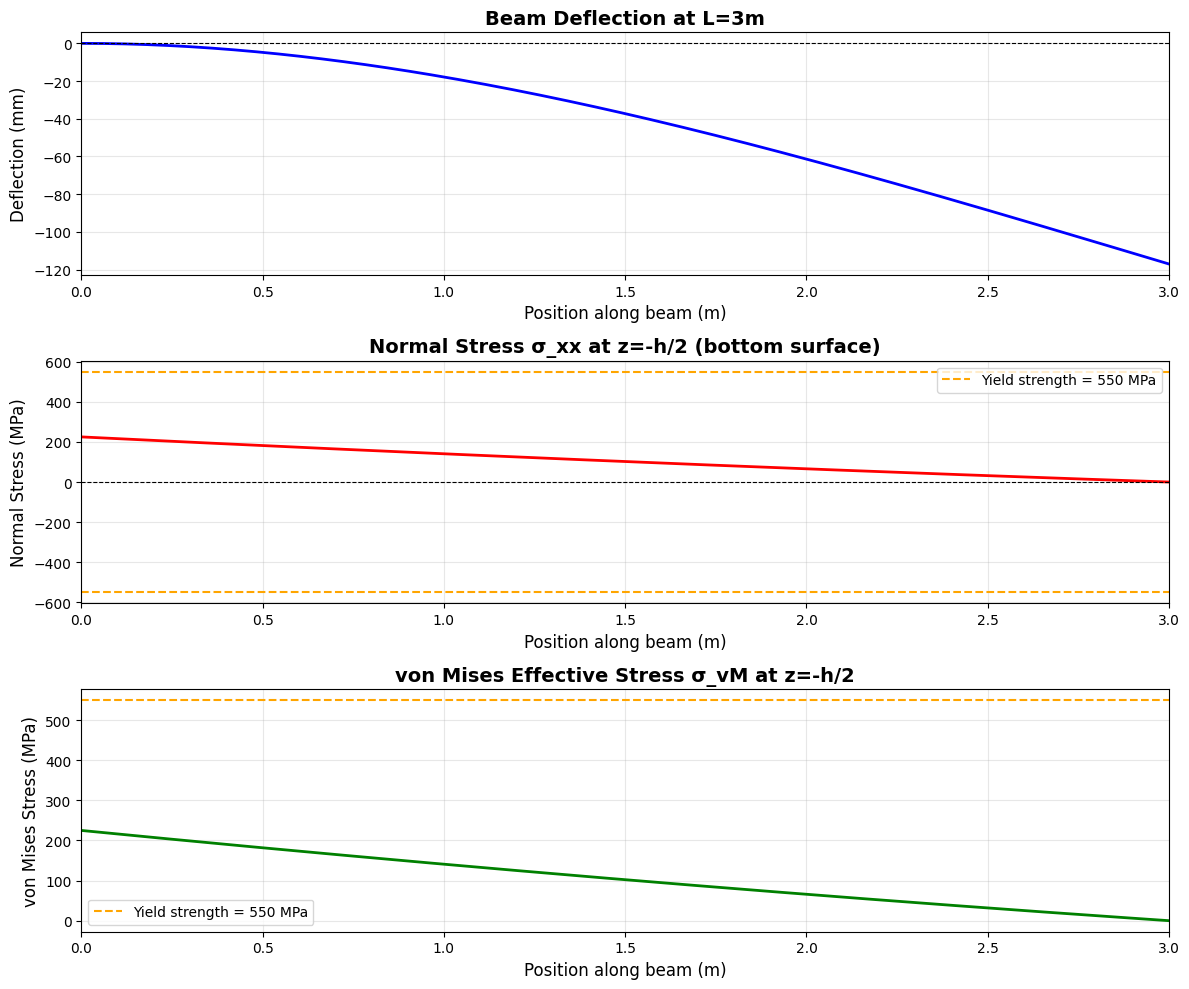


STRESS ANALYSIS RESULTS FOR L=3m
Beam properties:
  Length: 3 m
  Cross-section: 50.0 mm × 50.0 mm
  Material: Steel (E = 220 GPa, σ_yield = 550 MPa)

Loading:
  Distributed load q₀: -191.30 N/m
  Point load P: -1275.30 N (at free end)

Stress at z = -h/2 (bottom surface, maximum tension):
  Maximum |σ_xx|: 224.96 MPa
  Maximum σ_vM: 224.96 MPa
  Location of max stress: x = 0.000 m

Yield assessment (von Mises criterion):
  Yield strength: 550 MPa
  Safety factor: 2.44
 Beam is safe - No yielding expected

Data saved to 'beam_deflection.csv'
Data saved to 'normal_stress.csv'


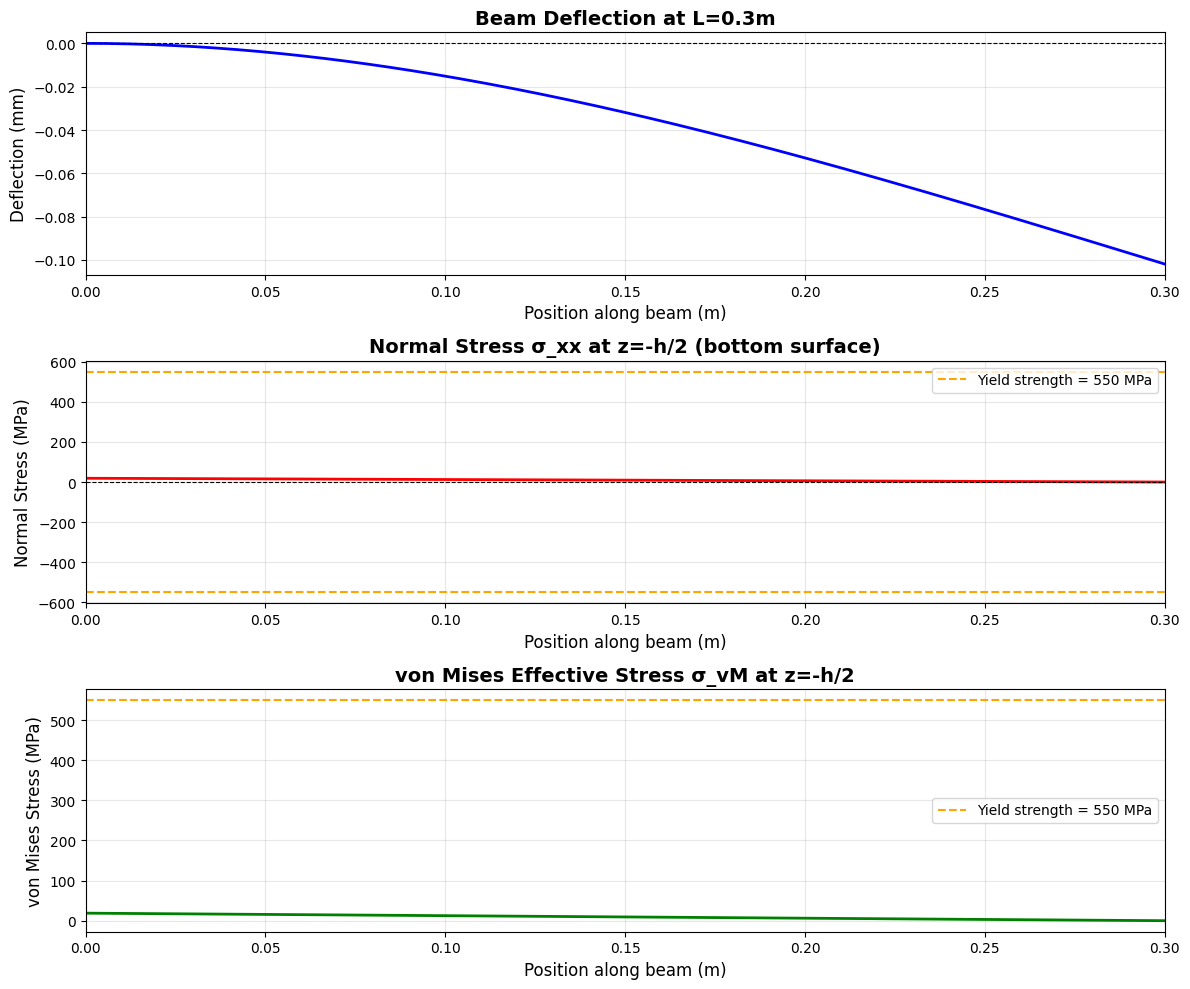


STRESS ANALYSIS RESULTS FOR L=0.3m
Beam properties:
  Length: 0.3 m
  Cross-section: 50.0 mm × 50.0 mm
  Material: Steel (E = 220 GPa, σ_yield = 550 MPa)

Loading:
  Distributed load q₀: -191.30 N/m
  Point load P: -1275.30 N (at free end)

Stress at z = -h/2 (bottom surface, maximum tension):
  Maximum |σ_xx|: 18.78 MPa
  Maximum σ_vM: 18.78 MPa
  Location of max stress: x = 0.000 m

Yield assessment (von Mises criterion):
  Yield strength: 550 MPa
  Safety factor: 29.29
 Beam is safe - No yielding expected



In [3]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
import pandas as pd

x, L, q0, P, E, I = symbols('x L q0 P E I')

w = Function('w')(x) # w is a function of x

diffeq1 = Eq(E*I * diff(w, x, 4), q0)

w = dsolve(diffeq1, w).rhs

M = -E*I*w.diff(x, 2)

#C1, C2, C3, C4 = symbols('C1 C2 C3 C4')

# Boundary conditions for distributed load
boundary_conditions1 = [ w.subs(x, 0),                          #w(0) = 0
                        w.diff(x).subs(x, 0),                   #w'(0) = 0
                        M.subs(x, L),                           #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

integration_constants = solve(boundary_conditions1, 'C1, C2, C3, C4', real=True)

display(integration_constants)

solution = w.subs(integration_constants)

display(simplify(solution))

w_func = lambdify((x, L, q0, P, E, I), solution, 'numpy')

# Create moment function with constants substituted
M_solution = M.subs(integration_constants)
M_func = lambdify((x, L, q0, P, E, I), M_solution, 'numpy')

# Yield strength for steel
sigma_yield = 550e6 

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

# Compute stresses at z = -h/2
z = -h/2
M_vals = M_func(x_vals, L, q0, P, E, I)
sigma_xx = -M_vals * z / I  # Normal stress from bending
sigma_vM = np.abs(sigma_xx)  # von Mises stress

# Find maximum stresses
max_sigma_xx = np.max(np.abs(sigma_xx))
max_sigma_vM = np.max(sigma_vM)
max_stress_location = x_vals[np.argmax(sigma_vM)]
safety_factor = sigma_yield / max_sigma_vM
will_yield = max_sigma_vM > sigma_yield

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Deflection
ax1.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
ax1.set_title(f'Beam Deflection at L={L}m', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position along beam (m)', fontsize=12)
ax1.set_ylabel('Deflection (mm)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.set_xlim(0, L)

# Saving data to .csv file
# Convert deflection to mm
w_mm = w_vals * 1e3

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Deflection (mm)': w_mm
})

# Save to CSV
df.to_csv('beam_deflection_euler_3m.csv', index=False)

print("Data saved to 'beam_deflection.csv'")

# Plot 2: Normal stress σ_xx
ax2.plot(x_vals, sigma_xx/1e6, 'r-', linewidth=2)
ax2.set_title('Normal Stress σ_xx at z=-h/2 (bottom surface)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Position along beam (m)', fontsize=12)
ax2.set_ylabel('Normal Stress (MPa)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax2.axhline(-sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--')
ax2.set_xlim(0, L)
ax2.legend()

## Saving plot data into a .csv file
# Convert stress to MPa
sigma_MPa = sigma_xx / 1e6

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Normal Stress (MPa)': sigma_MPa
})

# Save to CSV
df.to_csv('normal_stress_euler_3m.csv', index=False)

print("Data saved to 'normal_stress.csv'")

# Plot 3: von Mises stress
ax3.plot(x_vals, sigma_vM/1e6, 'g-', linewidth=2)
ax3.set_title('von Mises Effective Stress σ_vM at z=-h/2', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position along beam (m)', fontsize=12)
ax3.set_ylabel('von Mises Stress (MPa)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax3.set_xlim(0, L)
ax3.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"\n{'='*70}")
print(f"STRESS ANALYSIS RESULTS FOR L={L}m")
print(f"{'='*70}")
print(f"Beam properties:")
print(f"  Length: {L} m")
print(f"  Cross-section: {b*1e3:.1f} mm × {h*1e3:.1f} mm")
print(f"  Material: Steel (E = {E/1e9:.0f} GPa, σ_yield = {sigma_yield/1e6:.0f} MPa)")
print(f"\nLoading:")
print(f"  Distributed load q₀: {q0:.2f} N/m")
print(f"  Point load P: {P:.2f} N (at free end)")
print(f"\nStress at z = -h/2 (bottom surface, maximum tension):")
print(f"  Maximum |σ_xx|: {max_sigma_xx/1e6:.2f} MPa")
print(f"  Maximum σ_vM: {max_sigma_vM/1e6:.2f} MPa")
print(f"  Location of max stress: x = {max_stress_location:.3f} m")
print(f"\nYield assessment (von Mises criterion):")
print(f"  Yield strength: {sigma_yield/1e6:.0f} MPa")
print(f"  Safety factor: {safety_factor:.2f}")
if will_yield:
    print(f" BEAM WILL YIELD - Maximum stress exceeds yield strength!")
else:
    print(f" Beam is safe - No yielding expected")
print(f"{'='*70}\n")

L=L2

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

# Compute stresses at z = -h/2 (bottom surface)
z = -h/2
M_vals = M_func(x_vals, L, q0, P, E, I)
sigma_xx = -M_vals * z / I  # Normal stress from bending
sigma_vM = np.abs(sigma_xx)  # von Mises stress

# Find maximum stresses
max_sigma_xx = np.max(np.abs(sigma_xx))
max_sigma_vM = np.max(sigma_vM)
max_stress_location = x_vals[np.argmax(sigma_vM)]
safety_factor = sigma_yield / max_sigma_vM
will_yield = max_sigma_vM > sigma_yield

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Deflection
ax1.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
ax1.set_title(f'Beam Deflection at L={L}m', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position along beam (m)', fontsize=12)
ax1.set_ylabel('Deflection (mm)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.set_xlim(0, L)

## Saving plot data into a .csv file
# Convert deflection to mm
w_mm = w_vals * 1e3

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Deflection (mm)': w_mm
})

# Save to CSV
df.to_csv('beam_deflection_euler_0.3m.csv', index=False)
print("Data saved to 'beam_deflection.csv'")

# Plot 2: Normal stress σ_xx
ax2.plot(x_vals, sigma_xx/1e6, 'r-', linewidth=2)
ax2.set_title('Normal Stress σ_xx at z=-h/2 (bottom surface)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Position along beam (m)', fontsize=12)
ax2.set_ylabel('Normal Stress (MPa)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax2.axhline(-sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--')
ax2.set_xlim(0, L)
ax2.legend()

## Saving plot data into a .csv file
# Convert stress to MPa
sigma_MPa = sigma_xx / 1e6

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Normal Stress (MPa)': sigma_MPa
})

# Save to CSV
df.to_csv('normal_stress_euler_0.3m.csv', index=False)

print("Data saved to 'normal_stress.csv'")

# Plot 3: von Mises stress
ax3.plot(x_vals, sigma_vM/1e6, 'g-', linewidth=2)
ax3.set_title('von Mises Effective Stress σ_vM at z=-h/2', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position along beam (m)', fontsize=12)
ax3.set_ylabel('von Mises Stress (MPa)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax3.set_xlim(0, L)
ax3.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"\n{'='*70}")
print(f"STRESS ANALYSIS RESULTS FOR L={L}m")
print(f"{'='*70}")
print(f"Beam properties:")
print(f"  Length: {L} m")
print(f"  Cross-section: {b*1e3:.1f} mm × {h*1e3:.1f} mm")
print(f"  Material: Steel (E = {E/1e9:.0f} GPa, σ_yield = {sigma_yield/1e6:.0f} MPa)")
print(f"\nLoading:")
print(f"  Distributed load q₀: {q0:.2f} N/m")
print(f"  Point load P: {P:.2f} N (at free end)")
print(f"\nStress at z = -h/2 (bottom surface, maximum tension):")
print(f"  Maximum |σ_xx|: {max_sigma_xx/1e6:.2f} MPa")
print(f"  Maximum σ_vM: {max_sigma_vM/1e6:.2f} MPa")
print(f"  Location of max stress: x = {max_stress_location:.3f} m")
print(f"\nYield assessment (von Mises criterion):")
print(f"  Yield strength: {sigma_yield/1e6:.0f} MPa")
print(f"  Safety factor: {safety_factor:.2f}")
if will_yield:
    print(f" BEAM WILL YIELD - Maximum stress exceeds yield strength!")
else:
    print(f" Beam is safe - No yielding expected")
print(f"{'='*70}\n")

## Timoshenko beam theory

q0*x**4/(24*E*I) + x**3*(-L*q0 - P)/(6*E*I) + x**2*(L**2*q0 + 2*L*P)/(4*E*I) - q0*x**2/(2*A*G*Ks)

Data saved to 'beam_deflection.csv'
Data saved to 'normal_stress.csv'


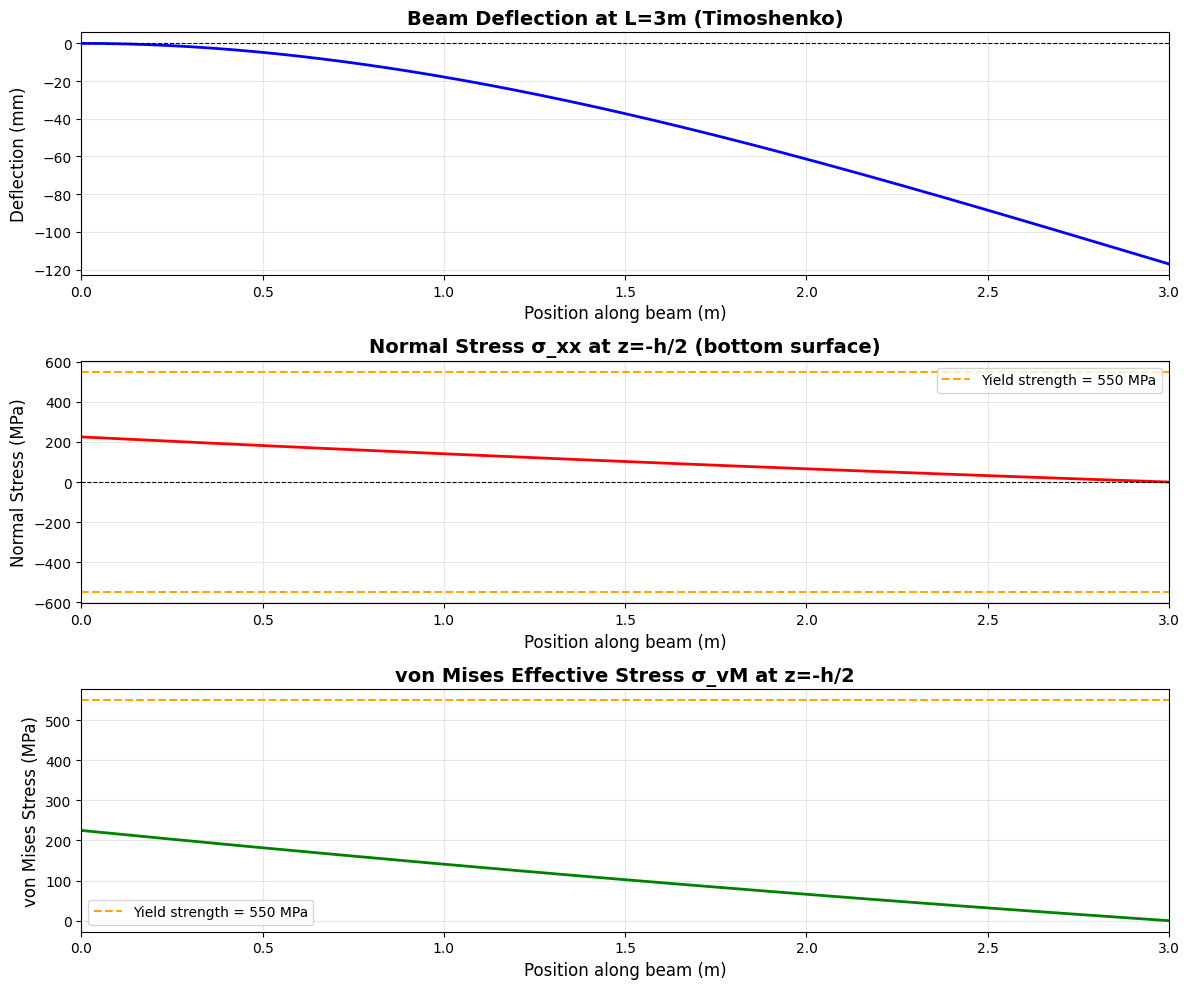


STRESS ANALYSIS RESULTS FOR L=3m (Timoshenko Beam Theory)
Beam properties:
  Length: 3 m
  Cross-section: 50.0 mm × 50.0 mm
  Material: Steel (E = 220 GPa, G = 84.6 GPa)
  Shear correction factor Ks: 0.833
  Yield strength: 550 MPa

Loading:
  Distributed load q₀: -191.30 N/m
  Point load P: -1275.30 N (at free end)

Stress at z = -h/2 (bottom surface, maximum tension):
  Maximum |σ_xx|: 224.96 MPa
  Maximum σ_vM: 224.96 MPa
  Location of max stress: x = 0.000 m

Yield assessment (von Mises criterion):
  Safety factor: 2.44
  Beam is safe - No yielding expected

Data saved to 'beam_deflection.csv'
Data saved to 'normal_stress.csv'


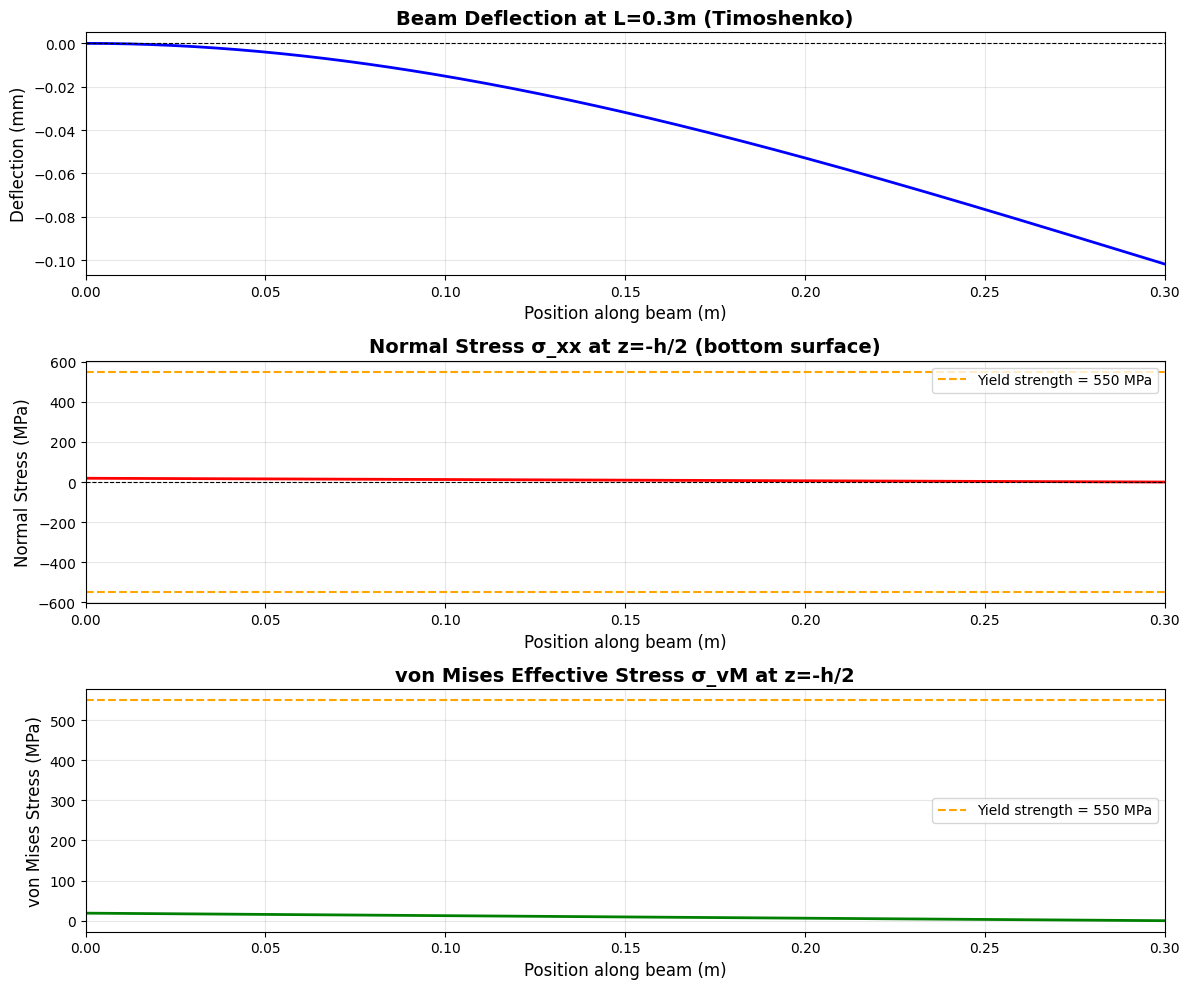


STRESS ANALYSIS RESULTS FOR L=0.3m (Timoshenko Beam Theory)
Beam properties:
  Length: 0.3 m
  Cross-section: 50.0 mm × 50.0 mm
  Material: Steel (E = 220 GPa, G = 84.6 GPa)
  Shear correction factor Ks: 0.833
  Yield strength: 550 MPa

Loading:
  Distributed load q₀: -191.30 N/m
  Point load P: -1275.30 N (at free end)

Stress at z = -h/2 (bottom surface, maximum tension):
  Maximum |σ_xx|: 18.78 MPa
  Maximum σ_vM: 18.78 MPa
  Location of max stress: x = 0.000 m

Yield assessment (von Mises criterion):
  Safety factor: 29.29
 Beam is safe - No yielding expected



In [4]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt


x, q0, E, I, Ks, G, A, L, P = symbols('x q0 E I Ks G A L P', real=True)

f_phi = Function('phi') # phi is a function of x

## Define the differential equation in terms of phi
diffeq_phi = Eq(E*I*f_phi(x).diff(x, 3), q0)

## Solve the differential equation for phi(x) (eq. 3.35 LN)
phi = dsolve(diffeq_phi, f_phi(x)).rhs

## Solve the differential equation for w(x) (eq. 3.36 LN)
w = Function('w') # w is a function of x
diffeq_w = Eq(w(x).diff(x), -E*I/(G*Ks*A)*phi.diff(x,2) + phi)
w        = dsolve(diffeq_w, w(x)).rhs

## Define boundary conditions
M = -E*I*phi.diff(x)
# Boundary conditions for distributed load
boundary_conditions = [ w.subs(x, 0),                           #w(0) = 0
                        w.diff(x).subs(x, 0),                   #w'(0) = 0
                        M.subs(x, L),                           #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

## Solve for the integration constants
integration_constants = solve(boundary_conditions, 'C1, C2, C3, C4', real=True)

## Substitute the integration constants into the solution
solution1 = w.subs(integration_constants)

display(solution1)

w_func = lambdify((x, L, q0, P, E, I, Ks, A, G), solution1, 'numpy')
# Create moment function with constants substituted
M_solution = M.subs(integration_constants)
M_func = lambdify((x, L, q0, P, E, I, Ks, A, G), M_solution, 'numpy')

sigma_yield = 550e6  

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g
Ks = 5/6
A = b*h
G = E/(2*(1+poisson)) 


x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

# Compute stresses at z = -h/2
z = -h/2
M_vals = M_func(x_vals, L, q0, P, E, I, A, G, Ks)
sigma_xx = -M_vals * z / I  # Normal stress from bending
sigma_vM = np.abs(sigma_xx)  # von Mises stress

# Find maximum stresses
max_sigma_xx = np.max(np.abs(sigma_xx))
max_sigma_vM = np.max(sigma_vM)
max_stress_location = x_vals[np.argmax(sigma_vM)]
safety_factor = sigma_yield / max_sigma_vM
will_yield = max_sigma_vM > sigma_yield

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Deflection
ax1.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
ax1.set_title(f'Beam Deflection at L={L}m (Timoshenko)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position along beam (m)', fontsize=12)
ax1.set_ylabel('Deflection (mm)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.set_xlim(0, L)

## Saving plot data into a .csv file
# Convert deflection to mm
w_mm = w_vals * 1e3

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Deflection (mm)': w_mm
})

# Save to CSV
df.to_csv('beam_deflection_timo_3m.csv', index=False)
print("Data saved to 'beam_deflection.csv'")

# Plot 2: Normal stress
ax2.plot(x_vals, sigma_xx/1e6, 'r-', linewidth=2)
ax2.set_title('Normal Stress σ_xx at z=-h/2 (bottom surface)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Position along beam (m)', fontsize=12)
ax2.set_ylabel('Normal Stress (MPa)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax2.axhline(-sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--')
ax2.set_xlim(0, L)
ax2.legend()

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Normal Stress (MPa)': sigma_MPa
})

# Save to CSV
df.to_csv('normal_stress_timo_3m.csv', index=False)

print("Data saved to 'normal_stress.csv'")

# Plot 3: von Mises stress
ax3.plot(x_vals, sigma_vM/1e6, 'g-', linewidth=2)
ax3.set_title('von Mises Effective Stress σ_vM at z=-h/2', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position along beam (m)', fontsize=12)
ax3.set_ylabel('von Mises Stress (MPa)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax3.set_xlim(0, L)
ax3.legend()

plt.tight_layout()
plt.show()


print(f"\n{'='*70}")
print(f"STRESS ANALYSIS RESULTS FOR L={L}m (Timoshenko Beam Theory)")
print(f"{'='*70}")
print(f"Beam properties:")
print(f"  Length: {L} m")
print(f"  Cross-section: {b*1e3:.1f} mm × {h*1e3:.1f} mm")
print(f"  Material: Steel (E = {E/1e9:.0f} GPa, G = {G/1e9:.1f} GPa)")
print(f"  Shear correction factor Ks: {Ks:.3f}")
print(f"  Yield strength: {sigma_yield/1e6:.0f} MPa")
print(f"\nLoading:")
print(f"  Distributed load q₀: {q0:.2f} N/m")
print(f"  Point load P: {P:.2f} N (at free end)")
print(f"\nStress at z = -h/2 (bottom surface, maximum tension):")
print(f"  Maximum |σ_xx|: {max_sigma_xx/1e6:.2f} MPa")
print(f"  Maximum σ_vM: {max_sigma_vM/1e6:.2f} MPa")
print(f"  Location of max stress: x = {max_stress_location:.3f} m")
print(f"\nYield assessment (von Mises criterion):")
print(f"  Safety factor: {safety_factor:.2f}")
if will_yield:
    print(f" BEAM WILL YIELD - Maximum stress exceeds yield strength!")
else:
    print(f"  Beam is safe - No yielding expected")
print(f"{'='*70}\n")

L=L2

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

# Compute stresses at z = -h/2
z = -h/2
M_vals = M_func(x_vals, L, q0, P, E, I, A, G, Ks)
sigma_xx = -M_vals * z / I  # Normal stress from bending
sigma_vM = np.abs(sigma_xx)  # von Mises stress

# Find maximum stresses
max_sigma_xx = np.max(np.abs(sigma_xx))
max_sigma_vM = np.max(sigma_vM)
max_stress_location = x_vals[np.argmax(sigma_vM)]
safety_factor = sigma_yield / max_sigma_vM
will_yield = max_sigma_vM > sigma_yield

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Deflection
ax1.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
ax1.set_title(f'Beam Deflection at L={L}m (Timoshenko)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position along beam (m)', fontsize=12)
ax1.set_ylabel('Deflection (mm)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.set_xlim(0, L)

## Saving plot data into a .csv file
# Convert deflection to mm
w_mm = w_vals * 1e3

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Deflection (mm)': w_mm
})

# Save to CSV
df.to_csv('beam_deflection_timo_0.3m.csv', index=False)
print("Data saved to 'beam_deflection.csv'")

# Plot 2: Normal stress
ax2.plot(x_vals, sigma_xx/1e6, 'r-', linewidth=2)
ax2.set_title('Normal Stress σ_xx at z=-h/2 (bottom surface)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Position along beam (m)', fontsize=12)
ax2.set_ylabel('Normal Stress (MPa)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax2.axhline(-sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--')
ax2.set_xlim(0, L)
ax2.legend()

# Create a DataFrame
df = pd.DataFrame({
    'Position (m)': x_vals,
    'Normal Stress (MPa)': sigma_MPa
})

# Save to CSV
df.to_csv('normal_stress_timo_0.3m.csv', index=False)

print("Data saved to 'normal_stress.csv'")

# Plot 3: von Mises stress
ax3.plot(x_vals, sigma_vM/1e6, 'g-', linewidth=2)
ax3.set_title('von Mises Effective Stress σ_vM at z=-h/2', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position along beam (m)', fontsize=12)
ax3.set_ylabel('von Mises Stress (MPa)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(sigma_yield/1e6, color='orange', linewidth=1.5, linestyle='--', label=f'Yield strength = {sigma_yield/1e6:.0f} MPa')
ax3.set_xlim(0, L)
ax3.legend()

plt.tight_layout()
plt.show()


print(f"\n{'='*70}")
print(f"STRESS ANALYSIS RESULTS FOR L={L}m (Timoshenko Beam Theory)")
print(f"{'='*70}")
print(f"Beam properties:")
print(f"  Length: {L} m")
print(f"  Cross-section: {b*1e3:.1f} mm × {h*1e3:.1f} mm")
print(f"  Material: Steel (E = {E/1e9:.0f} GPa, G = {G/1e9:.1f} GPa)")
print(f"  Shear correction factor Ks: {Ks:.3f}")
print(f"  Yield strength: {sigma_yield/1e6:.0f} MPa")
print(f"\nLoading:")
print(f"  Distributed load q₀: {q0:.2f} N/m")
print(f"  Point load P: {P:.2f} N (at free end)")
print(f"\nStress at z = -h/2 (bottom surface, maximum tension):")
print(f"  Maximum |σ_xx|: {max_sigma_xx/1e6:.2f} MPa")
print(f"  Maximum σ_vM: {max_sigma_vM/1e6:.2f} MPa")
print(f"  Location of max stress: x = {max_stress_location:.3f} m")
print(f"\nYield assessment (von Mises criterion):")
print(f"  Safety factor: {safety_factor:.2f}")
if will_yield:
    print(f" BEAM WILL YIELD - Maximum stress exceeds yield strength!")
else:
    print(f" Beam is safe - No yielding expected")
print(f"{'='*70}\n")

## Calfem with length 3m actual

'Ex'

array([[0.  , 0.03, 0.03, 0.  ],
       [0.03, 0.06, 0.06, 0.03],
       [0.06, 0.09, 0.09, 0.06],
       ...,
       [2.91, 2.94, 2.94, 2.91],
       [2.94, 2.97, 2.97, 2.94],
       [2.97, 3.  , 3.  , 2.97]])

'Ey'

array([[0.    , 0.    , 0.0025, 0.0025],
       [0.    , 0.    , 0.0025, 0.0025],
       [0.    , 0.    , 0.0025, 0.0025],
       ...,
       [0.0475, 0.0475, 0.05  , 0.05  ],
       [0.0475, 0.0475, 0.05  , 0.05  ],
       [0.0475, 0.0475, 0.05  , 0.05  ]])

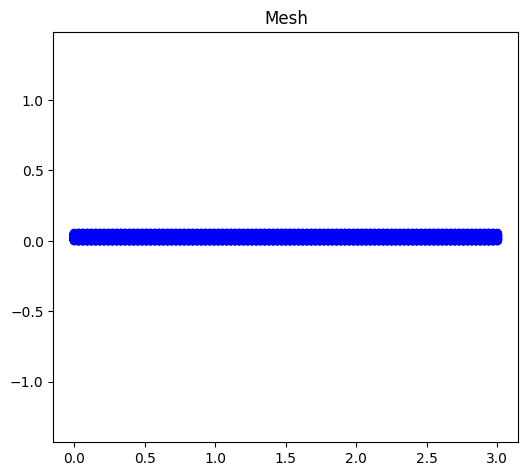

array([ 201,  202,  403,  404,  605,  606,  807,  808, 1009, 1010, 1211,
       1212, 1413, 1414, 1615, 1616, 1817, 1818, 2019, 2020, 2221, 2222,
       2423, 2424, 2625, 2626, 2827, 2828, 3029, 3030, 3231, 3232, 3433,
       3434, 3635, 3636, 3837, 3838, 4039, 4040, 4241, 4242], dtype=int32)

Total distributed load: -573.89 N
Point load: -1275.30 N
Total load: -1849.18 N

Maximum displacement: -9.688371e-02 m
Maximum displacement (mm): -96.8837 mm


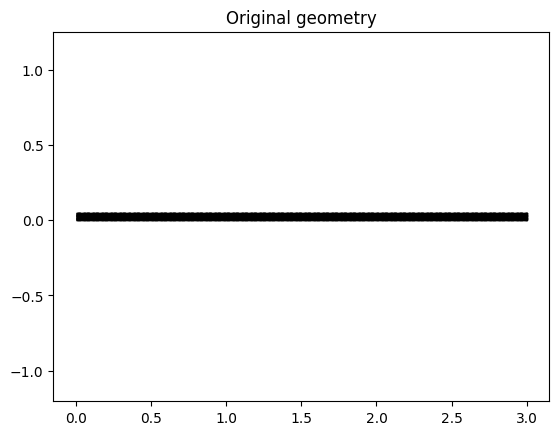

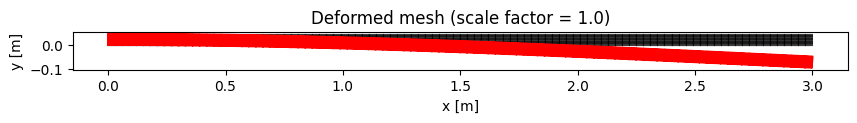

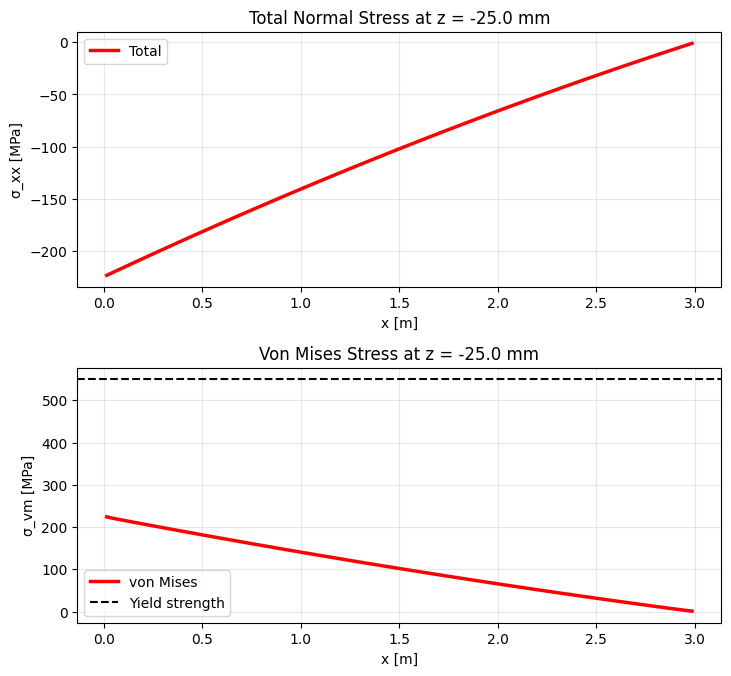

In [5]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv
import matplotlib.pyplot as plt
# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  
q0 = -h * b * rho * g  

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L1, h])   # Upper right corner
nelx = 100
nely = 20
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Generate mesh
Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)

display('Ex', Ex)
display('Ey', Ey)

# Plot mesh
cfv.figure()
cfv.eldraw2(Ex, Ey)
cfv.title('Mesh')
cfv.show()

display(B2)


# Initialize global stiffness matrix and force vector
K = np.zeros([nDofs, nDofs])
f = np.zeros([nDofs, 1])

# Assemble stiffness matrix
for eltopo, elx, ely in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)


# Top edge elements are those in the top row
top_elements = range(nelx * (nely - 1), nelx * nely)


# Aplying distributed load along the top edge downwards
top_elements = range(nelx * (nely - 1), nelx * nely)

for el_idx in top_elements:
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    eltopo = Edof[el_idx, :]

    # Top edge connects nodes 3 and 4
    edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)

    # Nodal force
    nodal_force = q0 * edge_length / 2.0

    # Applying the force to f vector
    f[eltopo[5] - 1] += nodal_force  
    f[eltopo[7] - 1] += nodal_force  


# Applying distributed load along the right edge
right_elements = range(nelx - 1, nelx * nely, nelx)

# Distributed load along right edge:
q_right = P / h

for el_idx in right_elements:
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    eltopo = Edof[el_idx, :]

    # Right edge connects nodes 2 and 3
    edge_length = np.sqrt((elx[1] - elx[2])**2 + (ely[1] - ely[2])**2)

    nodal_force = q_right * edge_length / 2.0

    # Apply to right edge noddes
    f[eltopo[3] - 1] += nodal_force
    f[eltopo[5] - 1] += nodal_force  


print(f"Total distributed load: {q0 * L1:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L1 + P:.2f} N")

# Applying boundary conditions 
bc = B4
bcval = np.zeros(np.size(bc))

# Solving the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extracting displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")

Ed = cfc.extract_eldisp(Edof, a)

# Deformations
plt.figure()
plotpar = [2, 1, 0] 
cfv.eldraw2(Ex, Ey, plotpar)  # Drawing the original geometry
plt.title('Original geometry')
# Drawing the deformed structure
#sfac = cfv.scalfact2(Ex[2, :], Ey[2, :], Ed[2, :], 1)
#plotpar = [1, 2, 1]
#sfac = 40  # Scaling factor to see the actual deformations
#cfv.eldisp2(Ex, Ey, Ed, plotpar, sfac)
#plt.title('Displacement')


# Compute nodal coordinates
xv = np.linspace(p1[0], p2[0], nelx + 1)
yv = np.linspace(p1[1], p2[1], nely + 1)
coords = np.array([[x, y] for y in yv for x in xv])  # (N, 2) array

# Deformed coordinates
U = a[0::2].reshape(-1, 1)  # x-displacements
V = a[1::2].reshape(-1, 1)  # y-displacements

sfac = 1  # deformation scale
coords_def = coords + sfac * np.hstack([U, V])

# Plot
plt.figure(figsize=(10, 3))
for elx, ely in zip(Ex, Ey):
    # Undeformed
    plt.plot(np.append(elx, elx[0]), np.append(ely, ely[0]), 'k-', lw=0.8, alpha=0.5)

for e, (elx, ely) in enumerate(zip(Ex, Ey)):
    # Get the deformed coordinates for each element
    nodes = ((Edof[e, ::ndof_per_node] - 1) // ndof_per_node).astype(int)
    x_def = coords_def[nodes, 0]
    y_def = coords_def[nodes, 1]
    plt.plot(np.append(x_def, x_def[0]), np.append(y_def, y_def[0]), 'r-', lw=1.0)

plt.gca().set_aspect('equal')
plt.title(f"Deformed mesh (scale factor = {sfac:.1f})")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()



# Initialize arrays to store stresses
num_elements = len(Ex)
stress_xx_membrane = np.zeros(num_elements)
stress_xx_bending = np.zeros(num_elements)
stress_xx_total = np.zeros(num_elements)
stress_yy = np.zeros(num_elements)
stress_xy = np.zeros(num_elements)
von_mises = np.zeros(num_elements)

# z-coordinate (negative because it's below the mid-plane)
z_eval = -h / 2.0

# Cross-sectional properties
I = (b * h**3) / 12.0

# Element center x-coordinates
elem_x_center = np.zeros(num_elements)

# Loop through all elements
for el_idx, (eltopo, elx, ely) in enumerate(zip(Edof, Ex, Ey)):
    ed = Ed[el_idx, :]
    
    # Compute stresses from plane stress FEM
    es, et = cfc.planqs(elx, ely, ep, Dmat, ed)
    
    stress_xx_membrane[el_idx] = es[0]
    stress_yy[el_idx] = es[1]
    stress_xy[el_idx] = es[2]
    
    # Element center x-coordinate
    elem_x_center[el_idx] = np.mean(elx)
    x_pos = elem_x_center[el_idx]
    
    # Bending moment: M(x) = -q0*(L1-x)²/2 - P*(L1-x)
    M_x = -q0 * (L1 - x_pos)**2 / 2.0 - P * (L1 - x_pos)
    
    # Bending stress at z = -h/2
    stress_xx_bending[el_idx] = M_x * z_eval / I
    
    # Total normal stress
    stress_xx_total[el_idx] = stress_xx_membrane[el_idx] + stress_xx_bending[el_idx]
    
    # Von Mises stress
    von_mises[el_idx] = np.sqrt(
        stress_xx_total[el_idx]**2 - 
        stress_xx_total[el_idx] * stress_yy[el_idx] + 
        stress_yy[el_idx]**2 + 
        3 * stress_xy[el_idx]**2
    )

# Sorting all arrays by x-coordinate for proper plotting
sort_idx = np.argsort(elem_x_center)
x_sorted = elem_x_center[sort_idx]
stress_xx_membrane_sorted = stress_xx_membrane[sort_idx]
stress_xx_bending_sorted = stress_xx_bending[sort_idx]
stress_xx_total_sorted = stress_xx_total[sort_idx]
stress_yy_sorted = stress_yy[sort_idx]
stress_xy_sorted = stress_xy[sort_idx]
von_mises_sorted = von_mises[sort_idx]


x_unique = np.unique(x_sorted)
n_x = len(x_unique)

stress_xx_mem_avg = np.zeros(n_x)
stress_xx_bend_avg = np.zeros(n_x)
stress_xx_tot_avg = np.zeros(n_x)
stress_yy_avg = np.zeros(n_x)
stress_xy_avg = np.zeros(n_x)
von_mises_avg = np.zeros(n_x)

for i, x_val in enumerate(x_unique):
    mask = np.abs(x_sorted - x_val) < 1e-10
    stress_xx_mem_avg[i] = np.mean(stress_xx_membrane_sorted[mask])
    stress_xx_bend_avg[i] = np.mean(stress_xx_bending_sorted[mask])
    stress_xx_tot_avg[i] = np.mean(stress_xx_total_sorted[mask])
    stress_yy_avg[i] = np.mean(stress_yy_sorted[mask])
    stress_xy_avg[i] = np.mean(stress_xy_sorted[mask])
    von_mises_avg[i] = np.mean(von_mises_sorted[mask])


# Plotting with sorted, averaged data
plt.figure(figsize=(14, 10))

# Plot 3: Normal stress
plt.subplot(3, 2, 3)
plt.plot(x_unique, stress_xx_tot_avg/1e6, 'r-', linewidth=2.5, label='Total')
plt.grid(True, alpha=0.3)
plt.xlabel('x [m]')
plt.ylabel('σ_xx [MPa]')
plt.title(f'Total Normal Stress at z = {z_eval*1000:.1f} mm')
plt.legend()

# Plot 5: Von Mises stress
plt.subplot(3, 2, 5)
plt.plot(x_unique, von_mises_avg/1e6, 'r-', linewidth=2.5, label='von Mises')
plt.axhline(y=sigma_yield/1e6, color='k', linestyle='--', linewidth=1.5, label='Yield strength')
plt.grid(True, alpha=0.3)
plt.xlabel('x [m]')
plt.ylabel('σ_vm [MPa]')
plt.title(f'Von Mises Stress at z = {z_eval*1000:.1f} mm')
plt.legend()

plt.tight_layout()
plt.show()

## Calfem with length 0.3m actual

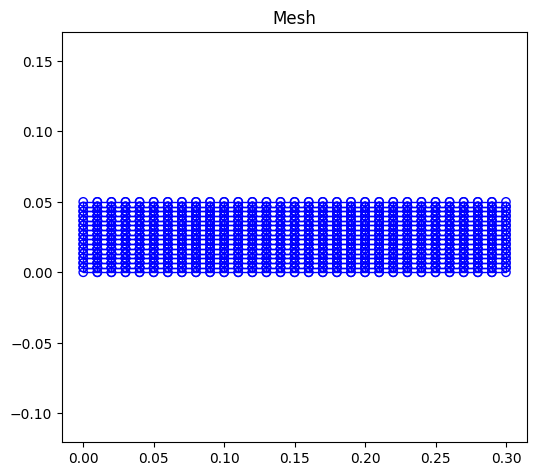

Total distributed load: -57.39 N
Point load: -1275.30 N
Total load: -1332.69 N

Maximum displacement: -1.012989e-04 m
Maximum displacement (mm): -0.1013 mm


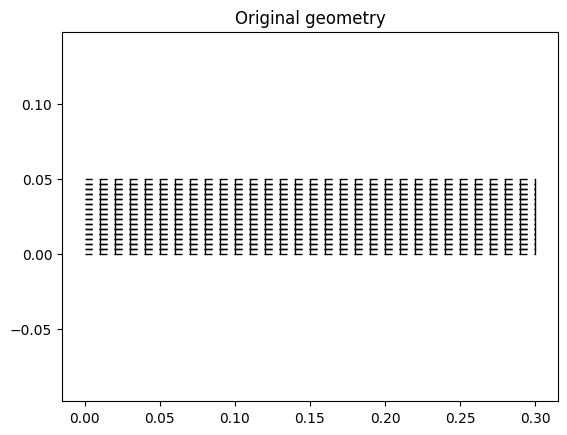

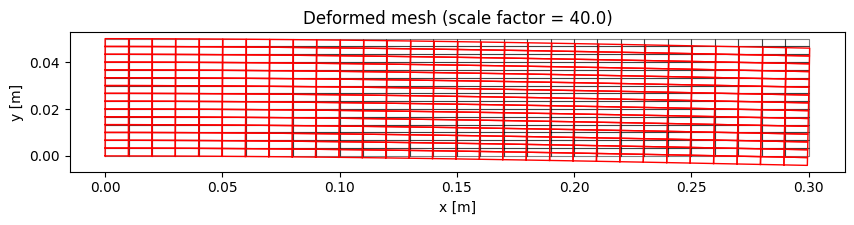

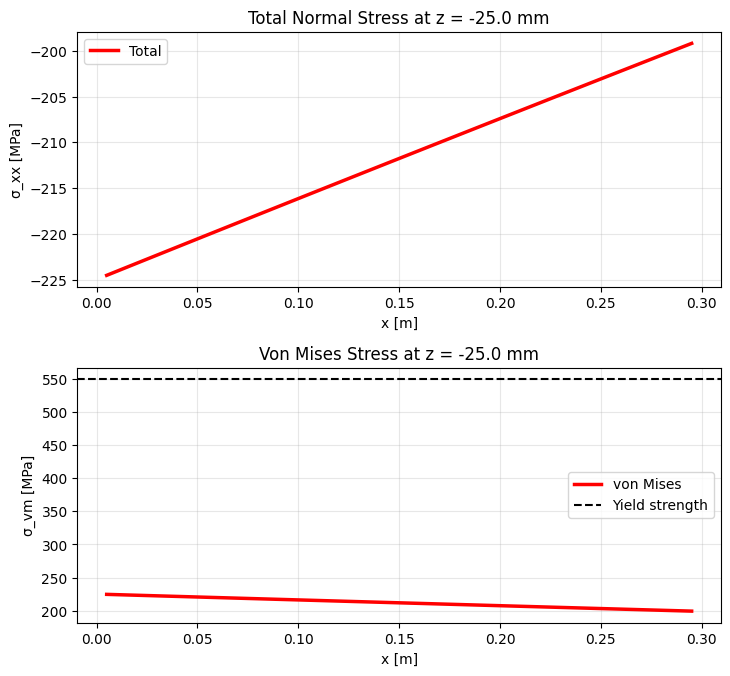

In [2]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv
import matplotlib.pyplot as plt
# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  # Point load
q0 = -h * b * rho * g  # Distributed load

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L2, h])   # Upper right corner
nelx = 30
nely = 15
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Generate mesh
Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)

#display('Ex', Ex)
#display('Ey', Ey)

# Plot mesh
cfv.figure()
cfv.eldraw2(Ex, Ey)
cfv.title('Mesh')
cfv.show()

#display(B2)


# Initializing global stiffness matrix and force vector
K = np.zeros([nDofs, nDofs])
f = np.zeros([nDofs, 1])

# Assemble stiffness matrix
for eltopo, elx, ely in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)


# Top edge elements are those in the top row
top_elements = range(nelx * (nely - 1), nelx * nely)


# Applying distributed load along the top edge
top_elements = range(nelx * (nely - 1), nelx * nely)

for el_idx in top_elements:
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    eltopo = Edof[el_idx, :]

    # Top edge connects nodes 3 and 4
    edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)

    # Nodal forces
    nodal_force = q0 * edge_length / 2.0

    # Apply to Y-DOFs
    f[eltopo[5] - 1] += nodal_force  
    f[eltopo[7] - 1] += nodal_force  


# Applying distributed load along the right edge
right_elements = range(nelx - 1, nelx * nely, nelx)

# Distributed load intensity along right edge:
q_right = P / h   

for el_idx in right_elements:
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    eltopo = Edof[el_idx, :]

    # Right edge connects nodes 2 and 3
    edge_length = np.sqrt((elx[1] - elx[2])**2 + (ely[1] - ely[2])**2)

    # Equivalent nodal forces for uniform distributed load q_right
    nodal_force = q_right * edge_length / 2.0

    # Apply to to right edge nodes in y-direction
    f[eltopo[3] - 1] += nodal_force  
    f[eltopo[5] - 1] += nodal_force  


print(f"Total distributed load: {q0 * L2:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L2 + P:.2f} N")

# Applying boundary conditions
bc = B4
bcval = np.zeros(np.size(bc))

# Solving the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extracting displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")

Ed = cfc.extract_eldisp(Edof, a)

# Deformations
plt.figure()
plotpar = [2, 1, 0]  # Plotting parameters
cfv.eldraw2(Ex, Ey, plotpar)  # Drawing the original geometry
plt.title('Original geometry')
# Drawing the deformed structure
#sfac = cfv.scalfact2(Ex[2, :], Ey[2, :], Ed[2, :], 1)
#plotpar = [1, 2, 1]
#sfac = 40  # Scaling factor to see the actual deformations
#cfv.eldisp2(Ex, Ey, Ed, plotpar, sfac)
#plt.title('Displacement')


# Compute nodal coordinates
xv = np.linspace(p1[0], p2[0], nelx + 1)
yv = np.linspace(p1[1], p2[1], nely + 1)
coords = np.array([[x, y] for y in yv for x in xv])  # (N, 2) array

# Deformed coordinates
U = a[0::2].reshape(-1, 1)  # x-displacements
V = a[1::2].reshape(-1, 1)  # y-displacements

sfac = 40  # deformation scale
coords_def = coords + sfac * np.hstack([U, V])

# Plot
plt.figure(figsize=(10, 3))
for elx, ely in zip(Ex, Ey):
    # Undeformed
    plt.plot(np.append(elx, elx[0]), np.append(ely, ely[0]), 'k-', lw=0.8, alpha=0.5)

for e, (elx, ely) in enumerate(zip(Ex, Ey)):
    # Get the deformed coordinates for each element
    nodes = ((Edof[e, ::ndof_per_node] - 1) // ndof_per_node).astype(int)
    x_def = coords_def[nodes, 0]
    y_def = coords_def[nodes, 1]
    plt.plot(np.append(x_def, x_def[0]), np.append(y_def, y_def[0]), 'r-', lw=1.0)

plt.gca().set_aspect('equal')
plt.title(f"Deformed mesh (scale factor = {sfac:.1f})")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()


sigma_yield = 550e6
# Initialize arrays to store stresses
num_elements = len(Ex)
stress_xx_membrane = np.zeros(num_elements)
stress_xx_bending = np.zeros(num_elements)
stress_xx_total = np.zeros(num_elements)
stress_yy = np.zeros(num_elements)
stress_xy = np.zeros(num_elements)
von_mises = np.zeros(num_elements)

# z-coordinate (negative because it's below the mid-plane)
z_eval = -h / 2.0

# Cross-sectional properties
I = (b * h**3) / 12.0

# Element center x-coordinates
elem_x_center = np.zeros(num_elements)

# Loop through all elements
for el_idx, (eltopo, elx, ely) in enumerate(zip(Edof, Ex, Ey)):
    ed = Ed[el_idx, :]
    
    # Compute stresses from plane stress FEM
    es, et = cfc.planqs(elx, ely, ep, Dmat, ed)
    
    stress_xx_membrane[el_idx] = es[0]
    stress_yy[el_idx] = es[1]
    stress_xy[el_idx] = es[2]
    
    # Element center x-coordinate
    elem_x_center[el_idx] = np.mean(elx)
    x_pos = elem_x_center[el_idx]
    
    # Bending moment: M(x) = -q0*(L1-x)²/2 - P*(L1-x)
    M_x = -q0 * (L1 - x_pos)**2 / 2.0 - P * (L1 - x_pos)
    
    # Bending stress at z = -h/2
    stress_xx_bending[el_idx] = M_x * z_eval / I
    
    # Total normal stress
    stress_xx_total[el_idx] = stress_xx_membrane[el_idx] + stress_xx_bending[el_idx]
    
    # Von Mises stress
    von_mises[el_idx] = np.sqrt(
        stress_xx_total[el_idx]**2 - 
        stress_xx_total[el_idx] * stress_yy[el_idx] + 
        stress_yy[el_idx]**2 + 
        3 * stress_xy[el_idx]**2
    )

# Sorting all arrays by x-coordinate for proper plotting
sort_idx = np.argsort(elem_x_center)
x_sorted = elem_x_center[sort_idx]
stress_xx_membrane_sorted = stress_xx_membrane[sort_idx]
stress_xx_bending_sorted = stress_xx_bending[sort_idx]
stress_xx_total_sorted = stress_xx_total[sort_idx]
stress_yy_sorted = stress_yy[sort_idx]
stress_xy_sorted = stress_xy[sort_idx]
von_mises_sorted = von_mises[sort_idx]


x_unique = np.unique(x_sorted)
n_x = len(x_unique)

stress_xx_mem_avg = np.zeros(n_x)
stress_xx_bend_avg = np.zeros(n_x)
stress_xx_tot_avg = np.zeros(n_x)
stress_yy_avg = np.zeros(n_x)
stress_xy_avg = np.zeros(n_x)
von_mises_avg = np.zeros(n_x)

for i, x_val in enumerate(x_unique):
    mask = np.abs(x_sorted - x_val) < 1e-10
    stress_xx_mem_avg[i] = np.mean(stress_xx_membrane_sorted[mask])
    stress_xx_bend_avg[i] = np.mean(stress_xx_bending_sorted[mask])
    stress_xx_tot_avg[i] = np.mean(stress_xx_total_sorted[mask])
    stress_yy_avg[i] = np.mean(stress_yy_sorted[mask])
    stress_xy_avg[i] = np.mean(stress_xy_sorted[mask])
    von_mises_avg[i] = np.mean(von_mises_sorted[mask])


# Plotting with sorted, averaged data
plt.figure(figsize=(14, 10))

# Normal stress
plt.subplot(3, 2, 3)
plt.plot(x_unique, stress_xx_tot_avg/1e6, 'r-', linewidth=2.5, label='Total')
plt.grid(True, alpha=0.3)
plt.xlabel('x [m]')
plt.ylabel('σ_xx [MPa]')
plt.title(f'Total Normal Stress at z = {z_eval*1000:.1f} mm')
plt.legend()

# Von Mises stress
plt.subplot(3, 2, 5)
plt.plot(x_unique, von_mises_avg/1e6, 'r-', linewidth=2.5, label='von Mises')
plt.axhline(y=sigma_yield/1e6, color='k', linestyle='--', linewidth=1.5, label='Yield strength')
plt.grid(True, alpha=0.3)
plt.xlabel('x [m]')
plt.ylabel('σ_vm [MPa]')
plt.title(f'Von Mises Stress at z = {z_eval*1000:.1f} mm')
plt.legend()

plt.tight_layout()
plt.show()


## Assignment 2 attempt 3 using own mesh varying area

In [ ]:
import numpy as np
import calfem.core as cfc
import matplotlib.pyplot as plt
from scipy import integrate

b_outer = 0.25
nu=0.3
E=200e9
h0 = 0.02
Width = b_outer
num_el = 500
nnodes = num_el + 1
a_inner = 0.15

coords = np.linspace(a_inner, b_outer, nnodes)

display(coords)
#coords = coords.reshape(-1,1)

Edof = np.zeros((num_el, 2), dtype=int)
for i in range(num_el):
    Edof[i, 0] = i + 1       # First column
    Edof[i, 1] = i + 2       # Second column

#display(coords)
display(Edof)

num_dofs = np.max(Edof)

#Dmat = E / (1-nu**2) * np.array([[1, nu],
                                 #[nu,1]])

num_dofs = np.max(Edof)
K = np.zeros((num_dofs, num_dofs))
f = np.zeros((num_dofs, 1))

print("K shape:", K.shape)

for el in range(num_el):
    r1 = coords[el]
    r2 = coords[el + 1]
    Le = r2 - r1
    r_mean = 0.5 * (r1 + r2)
    
    # variable thickness
    h_e = h0 * (r_mean - a_inner) / (b_outer - a_inner) + h0

    print('h_e',np.shape(h_e))
    print('r_mean',np.shape(r_mean))

    # local stiffness (axisymmetric linear element)
    Ke = (2 * np.pi * E * h_e * r_mean / Le) * np.array([[1, -1],
                                                        [-1,  1]])
    cfc.assem(Edof[el, :], K, Ke)

# BCs
bc = np.array([1])  # fix inner radius
bcVal = np.array([0.0])

# Applying distributed load
sigma_r = -120e6 
r_inner = coords[-1]
h_inner = h0
f[-1, 0] = 2 * np.pi * r_inner * h_inner * sigma_r  # negative radial direction


a, r = cfc.solveq(K, f, bc, bcVal)


plt.figure(figsize=(6,4))
plt.plot(coords, a * 1e3, 'o-', label='$u_r(r)$ [mm]')
plt.xlabel('r [m]')
plt.ylabel('Radial displacement [mm]')
plt.title('Axisymmetric radial displacement of disc')
plt.grid(True)
plt.legend()
plt.show()


for i in range(nnodes):
    print(f"Node {i+1}: r = {coords[i]:.4f} m, ur = {a[i,0]*1e6:.3f} μm")

# Computinging normal stress
sigma_rr_vals = np.zeros(num_el)
r_centers = np.zeros(num_el)

for el in range(num_el):
    r1 = coords[el]
    r2 = coords[el + 1]
    Le = r2 - r1
    r_mean = 0.5 * (r1 + r2)
    r_centers[el] = r_mean

    u1 = a[el, 0]
    u2 = a[el + 1, 0]
    du_dr = (u2 - u1) / Le

    # Plane stress approximation
    sigma_rr = E / (1 - nu**2) * (du_dr + nu * (u1 + u2) / (2 * r_mean))
    sigma_rr_vals[el] = sigma_rr

# Plotting radial stress
plt.figure(figsize=(6,4))
plt.plot(r_centers, sigma_rr_vals/1e6, 'o-', label=r'$\sigma_{rr}$ [MPa]')
plt.xlabel('r [m]')
plt.ylabel(r'$\sigma_{rr}$ [MPa]')
plt.title('Radial stress distribution σ_rr(r)')
plt.grid(True)
plt.legend()
plt.show()

## Assignment 2 constant area

In [ ]:
import numpy as np
import calfem.core as cfc
import matplotlib.pyplot as plt
from scipy import integrate

b_outer = 0.25
nu=0.3
E=200e9
h0 = 0.02
Width = b_outer
num_el = 500
nnodes = num_el + 1
a_inner = 0.15

coords = np.linspace(a_inner, b_outer, nnodes)

display(coords)
#coords = coords.reshape(-1,1)

Edof = np.zeros((num_el, 2), dtype=int)
for i in range(num_el):
    Edof[i, 0] = i + 1       
    Edof[i, 1] = i + 2       

#display(coords)
display(Edof)

num_dofs = np.max(Edof)

#Dmat = E / (1-nu**2) * np.array([[1, nu],
                                 #[nu,1]])

num_dofs = np.max(Edof)
K = np.zeros((num_dofs, num_dofs))
f = np.zeros((num_dofs, 1))

print("K shape:", K.shape)

for el in range(num_el):
    r1 = coords[el]
    r2 = coords[el + 1]
    Le = r2 - r1
    r_mean = 0.5 * (r1 + r2)
    
    # Constant thickness
    h_e = h0

    print('h_e',np.shape(h_e))
    print('r_mean',np.shape(r_mean))

    # local stiffness (axisymmetric linear element)
    Ke = (2 * np.pi * E * h_e * r_mean / Le) * np.array([[1, -1],
                                                        [-1,  1]])
    cfc.assem(Edof[el, :], K, Ke)

# BCs
bc = np.array([1])  # fix inner radius
bcVal = np.array([0.0])

# Applying distributed load
sigma_r = -120e6 
r_outer = coords[-1]
h_inner = h0
f[-1, 0] = 2 * np.pi * r_outer * h_inner * sigma_r  # negative radial direction


a, r = cfc.solveq(K, f, bc, bcVal)


plt.figure(figsize=(6,4))
plt.plot(coords, a * 1e3, 'o-', label='$u_r(r)$ [mm]')
plt.xlabel('r [m]')
plt.ylabel('Radial displacement [mm]')
plt.title('Axisymmetric radial displacement of disc')
plt.grid(True)
plt.legend()
plt.show()


for i in range(nnodes):
    print(f"Node {i+1}: r = {coords[i]:.4f} m, ur = {a[i,0]*1e6:.3f} μm")

# Computing normal stress
sigma_rr_vals = np.zeros(num_el)
r_centers = np.zeros(num_el)

for el in range(num_el):
    r1 = coords[el]
    r2 = coords[el + 1]
    Le = r2 - r1
    r_mean = 0.5 * (r1 + r2)
    r_centers[el] = r_mean

    u1 = a[el, 0]
    u2 = a[el + 1, 0]
    du_dr = (u2 - u1) / Le

    # Plane stress approximation
    sigma_rr = E / (1 - nu**2) * (du_dr + nu * (u1 + u2) / (2 * r_mean))
    sigma_rr_vals[el] = sigma_rr

# Plotting radial stress
plt.figure(figsize=(6,4))
plt.plot(r_centers, sigma_rr_vals/1e6, 'o-', label=r'$\sigma_{rr}$ [MPa]')
plt.xlabel('r [m]')
plt.ylabel(r'$\sigma_{rr}$ [MPa]')
plt.title('Radial stress distribution σ_rr(r)')
plt.grid(True)
plt.legend()
plt.show()


print("Total reaction force:", np.sum(r))
print("Expected load:", 2*np.pi*coords[-1]*h0*(-sigma_r))

print(f"Applying σ_rr = {sigma_r/1e6:.1f} MPa at r = {r_outer:.3f} m")
print(f"Equivalent nodal force = {f[-1,0]:.2f} N")

## Mesh study assignment 1 L=3 and L=0.3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data 1 from mesh study (L=3)
data1 = [
    (2000, -96.8837),
    (3000, -107.1399),
    (3000, -96.8784),
    (3600, -102.2611),
    (3600, -109.9881),
    (4000, -111.2657),
    (4500, -107.1336),
    (5000, -113.2861),
    (6000, -114.4148),
    (7500, -113.2799),
    (8000, -115.5584),
    (10000, -116.0937),
    (12000, -116.3842),
    (13000, -116.4816)
]

# Data 2 from mesh study (L=?)
data2 = [
    (80, -0.0979),
    (450, -0.1013),
    (600, -0.1024),
    (750, -0.1028),
    (1500, -0.1035),
    (2000, -0.1035),
    (4000, -0.1037)
]

# Function to process data
def process_data(data):
    # Remove duplicates and sort by cells
    unique_data = {}
    for cells_val, disp_val in data:
        if cells_val not in unique_data:
            unique_data[cells_val] = disp_val
    
    # Sort by cells
    sorted_pairs = sorted(unique_data.items(), key=lambda x: x[0])
    cells_sorted = [pair[0] for pair in sorted_pairs]
    displacement_sorted = [pair[1] for pair in sorted_pairs]
    
    return cells_sorted, displacement_sorted

# Process both datasets
cells1, displacement1 = process_data(data1)
cells2, displacement2 = process_data(data2)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1
ax1.plot(cells1, displacement1, 'b-o', linewidth=2, markersize=8, label='Maximum Displacement')
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Number of Cells', fontsize=12, fontweight='bold')
ax1.set_ylabel('Maximum Displacement (mm)', fontsize=12, fontweight='bold')
ax1.set_title('Mesh Convergence Study (L = 3 m)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.ticklabel_format(style='plain', axis='x')


# Plot 2
ax2.plot(cells2, displacement2, 'r-s', linewidth=2, markersize=8, label='Maximum Displacement')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Number of Cells', fontsize=12, fontweight='bold')
ax2.set_ylabel('Maximum Displacement (mm)', fontsize=12, fontweight='bold')
ax2.set_title('Mesh Convergence Study (L = 0.3)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.ticklabel_format(style='plain', axis='x')


plt.tight_layout()
plt.show()